<a href="https://colab.research.google.com/github/Se00n00/Physician-Notetaker/blob/main/Notebooks/Sentiment_%26_Intent_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of sentiment analysis to detect patient concerns and reassurance needs

**Install the Required Dependecies**

In [ ]:
!pip install transformers torch sentencepiece kagglehub[pandas-datasets]

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "Mental Health Dataset.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sujaykapadnis/mental-health-insights-data",
  file_path,
)

print("First 5 records:", df.head())

/tmp/ipython-input-3660722623.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'mental-health-insights-data' dataset.
First 5 records:                                                posts predicted  intensity
0  I know as parent of child with down syndrome t...  negative         -1
1  but in my heart I know this is the future prom...   neutral          0
2  I have mylefibrosis which turn to leukemia the...  negative         -1
3  from one of my health group subject wayne dyer...   neutral          0
4  gmos now link to leukemia http nsnbc I 2013 07...   neutral          0


### Preprocessing

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df

,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0
...,...,...,...
10387,hey everyone I am a 25 year old male I work ou...,negative,-1
10388,have surgery for stage 1 colon cancer 1 year a...,very negative,-2
10389,the doctor advise we he could not remove the a...,neutral,0
10390,my 66 year old father have been through so muc...,neutral,0


In [7]:
df['posts'].str.len().describe()

,posts
count,10391.000000
mean,1178.169281
std,1583.707073
min,2.000000
25%,452.000000
50%,787.000000
75%,1344.000000
max,30504.000000


In [8]:
df.isna().sum()
df.dropna(inplace=True)
df.drop(columns=['intensity'], inplace=True)

In [13]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['predicted'])
X_train, X_test, y_train, y_test = train_test_split(df['posts'], df['label'], test_size=0.2, random_state=42)

*We may Chunk the rows to meet our BERT model's 512 token limit !*

### Fine-Tunning pre-Trained BERT Model

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [16]:
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased')

X_train_tokenize = tokenizer(list(X_train), padding=True, truncation=True, max_length=512)
X_test_tokenize = tokenizer(list(X_test), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
from datasets import Dataset

In [18]:
train_dataset = Dataset.from_dict({
    'input_ids': X_train_tokenize['input_ids'],
    'attention_mask': X_train_tokenize['attention_mask'],
    'labels': list(y_train)
})

test_dataset = Dataset.from_dict({
    'input_ids': X_test_tokenize['input_ids'],
    'attention_mask': X_test_tokenize['attention_mask'],
    'labels': list(y_test)
})

In [19]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(le.classes_))
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

**Training**

In [21]:
import wandb
wandb.init(project="Medical Sentiment Analysis", mode="offline")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.719900,0.682787
2,0.616300,0.524449
3,0.483800,0.509897


### Evaluate

                      precision    recall  f1-score   support

             Anxiety       0.82      0.84      0.83        83
             Bipolar       0.59      0.75      0.66        56
          Depression       0.79      0.66      0.72       369
              Normal       0.95      0.96      0.95       379
Personality disorder       0.45      0.21      0.29        24
              Stress       0.55      0.58      0.57        55
            Suicidal       0.63      0.76      0.69       234

            accuracy                           0.78      1200
           macro avg       0.68      0.68      0.67      1200
        weighted avg       0.78      0.78      0.78      1200



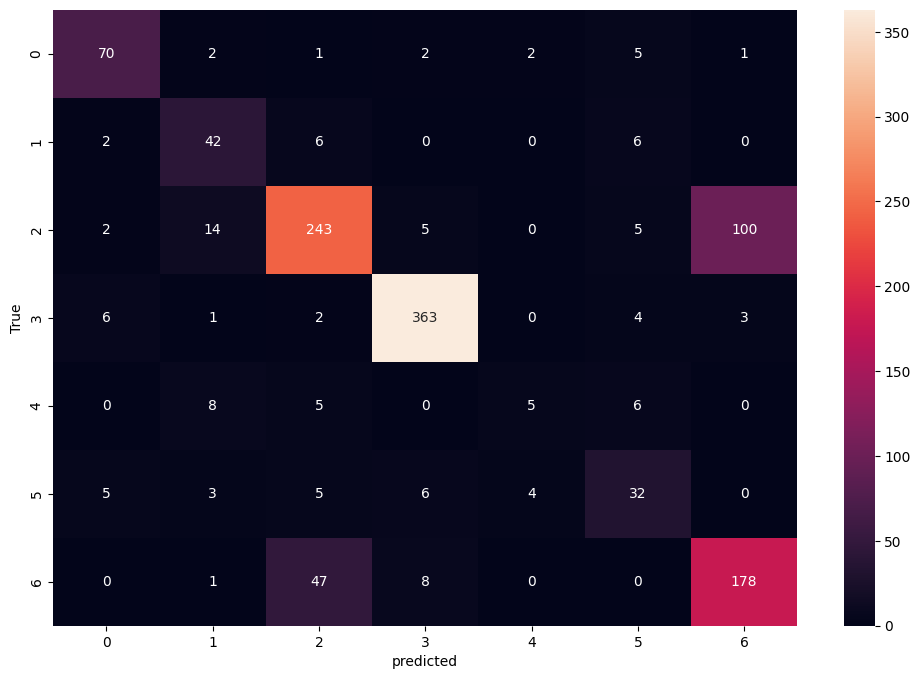

In [ ]:
pred, labels, _ = trainer.predict(test_dataset)

predicted_labels = np.argmax(pred, axis=1)

print(classification_report(y_test, predicted_labels, target_names=le.classes_))

cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import numpy as np

In [ ]:
def analyze_sentiment(dialoge:str)->str:
  id2label = {0: "neutral", 1: "negative", 2: "very negative", 3: "positive"}
  encoded = tokenizer(
        [dialoge],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
  )

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  encoded = {k: v.to(device) for k, v in encoded.items()}

  with torch.no_grad():
      outputs = model(**encoded)
      predicted_label_id = torch.argmax(outputs.logits, dim=1).item()

  return id2label[predicted_label_id]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def analyze_intent(text:str):
  prompt = f"Classify the {text} in following intent: [Seeking reassurance, Reporting symptoms, Expressing concern]"
  inputs = tokenizer(prompt, return_tensors="pt")
  outputs = model.generate(**inputs)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)

Here to get the intent of patient i used T5 model which is text2text (seq2seq) model which is instruction tuned.

-  One of the main reason was lack of proper dataset. as no dataset had its intent similier to the required ones
-  T5 had already proven capabilities with dealing with text-to-text problems as a generallized problem of classification, summerization, translateion and other NLP tasks.
-  While the base T5 is a generative model, its nature of predcting next token (pre-training objective) limits its capability to follow prompts and hence i used an instruction tuned t5-model

### **Sentiment_&_Intent_Analysis**

In [ ]:
def analyze_sentiment_and_intent(dialoge:str)->str:
  """
  analyze the given dialog and answer its sentiment as : Anxious, Neutral, or Reassured
  also, gives intent of the patient as: Seeking reassurance,” “Reporting symptoms,” “Expressing concern”

  params:
    dialogue: dialog of patient

  returns:
    sentiment: Anxious, Neutral, or Reassured
    intent: "Seeking reassurance,” “Reporting symptoms,” “Expressing concern”
  """
  return {
      "Sentiment" : analyze_sentiment(dialoge),
      "Intent" : analyze_intent(dialoge)
    }

# Answer: How would you fine-tune BERT for medical sentiment detection?

After Dataset(2) is pre-processed,
-  i would be splitting it into train:test in 8:2 ratio.
-  Further, tokenizing and then converting it into torch datasets.

```python
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5, # Initial learning Rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01, # Regularization to prevent overfitting
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear", # learning rate starts at - learning_rate and decays linearly to 0
    warmup_steps=500, # A warmup which gradually increases learning rate for first 500 steps reaching -learning_rate > Helps preventing unstable learning early on
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)
```

Since I used `AutoModelForSequenceClassification` for loading pretrained bert. the model's forward pass computes CrossEntropyLoss

In Summary, I performed essential preprocessing on medical health sentiment dataset(2) and then used Cross entropy loss to fine-tune the `pretrained BERT` model.
<br>
Here i used a initial warmup step to stablize the training and learning rate decay to improve convergence

# Answer: What datasets would you use for training a healthcare-specific sentiment model?

```
@dataset (1){
      title={Sentiment Analysis for Mental Health},
      author={Suchintika Sarkar},
      source={kaggle.com}
      dataset_classess=[
          Normal,
          Depression,
          Suicidal,
          Anxiety,
          Stress,
          Bi-Polar,
          Personality Disorder
      ]
      url={https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health},
}
```

The above Dataset from Kaggle was used to fine-tune the BERT model. Since the patient dialogue includes data from various sources:

   - *3k Conversations Dataset for Chatbot*
   - *Depression Reddit Cleaned*
   - *Human Stress Prediction*
   - *Predicting Anxiety in Mental Health Data*
   - *Mental Health Dataset Bipolar*
   - *Reddit Mental Health Data*
   - *Students Anxiety and Depression Dataset*
   - *Suicidal Mental Health Dataset*
   - *Suicidal Tweet Detection Dataset*
  
  This makes the corpus diverse for understanding sentiment of patient's dialogue.

The Above dataset(1) lacks postive sentiment examples. while negative onces dominates 7:3 to neutral ones which make the dataset highly unbalanced.

```
@dataset (1){
      title={Mental Health [Sentiment Analysis] Data},
      author={Sujay Kapadnis},
      source={kaggle.com}
      dataset_classess=[
          neutral,
          negative,
          very negative
          positive,
      ]
      url={https://www.kaggle.com/datasets/sujaykapadnis/mental-health-insights-data},
}
```

However, this dataset(2) contains text which aligns to general conveersation rather than dataset(1) whose text are more focused on topics like
- [Depression, Suicidal, Anxiety, Stress, Bi-Polar, Personality Disorder]

which is not oriented to a generic conversation and hence i decided to go with dataset(2)